## imports

In [1]:
import logging
import math
import os
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from typing import List

plt.style.use('fivethirtyeight')

logging.getLogger().setLevel('INFO')

## constants

In [2]:
PATH = '../covidclinicaldata/data'

LABEL = 'covid19_test_results'
LABEL_VALUES = ['Negative', 'Positive',]

SYMPTOMS = [
    'labored_respiration',
    'rhonchi',
    'wheezes',
    'cough',
    'cough_severity',
    'loss_of_smell',
    'loss_of_taste',
    'runny_nose',
    'muscle_sore',
    'sore_throat',
    'fever',
    'sob', 
    'sob_severity', 
    'diarrhea', 
    'fatigue', 
    'headache',
    'ctab',
]

VITALS = [
    'temperature', 
    'pulse', 
    'sys', 
    'dia', 
    'rr',
    'sats', 
]

COMORBIDITIES = [
    'diabetes', 
    'chd', 
    'htn', 
    'cancer', 
    'asthma',
    'copd', 
    'autoimmune_dis',
    'smoker',
]

RISKS = [
    'high_risk_exposure_occupation',
    'high_risk_interactions',
]


## util functions

In [3]:
def open_data() -> pd.DataFrame:
    '''Open all data in `PATH`.
    
    Returns
    -------
    pandas.DataFrame
    '''    
    return pd.concat(
        [
            pd.read_csv(f'{PATH}/{filename}') 
            for filename in os.listdir(PATH) 
            if filename.endswith('.csv')
        ]
    )


def get_percent(x: int, total: int) -> float:
    '''Return percentage.

    Returns 0 if `total` == 0 to bypass `division by 0` error. 

    Parameters
    ----------
    x : int
        The numerator.
    total : int
        The denominator.

    Returns
    -------
    float
    '''
    if total == 0:
        logging.info(f'Returning 0 to avoid `division by 0` error.')
        return 0

    return (x / total) * 100



## filtering functions

In [4]:
def filter_pos(data: pd.DataFrame) -> pd.DataFrame:
    '''Filter data on cases where `LABEL` column is 'Positive'.

    Parameters
    ----------
    data : pandas.DataFrame

    Returns
    -------
    pandas.DataFrame
    '''
    return data[data[LABEL] == 'Positive']


def filter_patients(
    df: pd.DataFrame, cols_to_check: List[str], col_type: str='bool'
) -> pd.DataFrame:
    '''Filter data if `cols_to_check` values are present in the data.

    `cols` can be `SYMPTOMS`, `VITALS`, or any other list of features.

    Expample: detects asymptomatic patients by checking where there are no `True` 
    in `SYMPTOMS` columns. Confirm that a `True` indicates a symptom or 
    abnormality. If not, use `reverse_bool` function to flip True/False values.

    Parameters
    ----------
    df : pandas.DataFrame
    cols : List[str]
    col_type : str, default='bool'
        Either `bool` (if columns are boolean columns) or `numeric` (if columns 
        are ints or floats).

    Returns
    -------
    df : pandas.DataFrame
    '''
    logging.info('Filtering out patients...')

    if col_type == 'bool':
        f = is_any_true
    elif col_type == 'numeric':
        f = is_any_nonnull
    else:
        logging.info('ERROR: `col_type` should be either `bool` or `numeric`.')
        return None

    df_filtered = df[df.apply(lambda x: f(x, cols_to_check), axis=1)]
    logging.info(
      f'    ---- {len(df)} --> {len(df_filtered)} '
      f'({get_percent(len(df_filtered), len(df)):.2f}%)'
    )

    return df_filtered


def is_any_true(row: pd.Series, cols: List[str]) -> bool:
    '''Check whether rows exhibit True for any values in `cols`.

    Parameters
    ----------
    row : pandas.Series
        pandas.DataFrame Row 
    cols : List[str]
        Columns to look through (can be `symptoms`, `vitals`, etc.)

    Returns
    -------
    bool
    '''
    return any(row[col] == True for col in cols)


def is_any_nonnull(row: pd.Series, cols: List[str]) -> bool:
    '''Check whether there is at least one non-empty value in `cols`.

    Parameters
    ----------
    row : pandas.Series
        pandas.DataFrame Row 
    cols : List[str]
        Columns to look through (can be `symptoms`, `vitals`, etc.)

    Returns
    -------
    bool
    '''
    return any(not math.isnan(row[col]) for col in cols)



## logging functions

In [5]:
def print_data_info(data: pd.DataFrame):
    '''Print out information on columns containing only one unique value.

    Parameters
    ----------
    data : pandas.DataFrame
    '''
    for col in data.columns:
        if len(data[col].unique()) == 1:
            logging.info(
                f'`{col}` only has single unique value of {data[col].iloc[0]} '
                'in entire dataset.'
            )



## plotting functions

In [6]:
def get_color(col: str) -> str:
    '''Get color for plot. 

    Different color depending on category of feature. `black` if color doesn't 
    belong in any of the pre-defined categories.

    Parameters
    ----------
    col : str
      The column name.

    Returns
    -------
    str
      `matplotlib` named color.     
    '''
    if col in VITALS:
        return 'lightcoral'
    if col in SYMPTOMS:
        return 'lightseagreen'
    if col in RISKS:
        return 'darkred'
    if col in COMORBIDITIES:
        return 'skyblue'
    return 'black'


def plot_fill_rates(data: pd.DataFrame, title: str=''):
    '''Plot fill rates of all the columns in the data.

    Parameters
    ----------
    data : pd.DataFrame
        The data.
    title : str, default=''
        The title for the plot. Empty string if no title.
    '''
    total = len(data)
    cols = data.columns

    plt.figure(figsize=(10, 7))
    for i, col in enumerate(cols):
        num_fill = sum(~data[col].isnull())

        plt.bar(i, num_fill, color=get_color(col))

    plt.ylabel('Fill Rate')
    plt.xticks(range(len(cols)), cols, rotation='vertical')
    plt.title(title)
    plt.show()


## check if any abnormalities reported in xray scans

In [7]:
ABNORMALITIES = [
    r'.+(lobe|RML|peribronchial|basilar) infiltrate',
    'lobe scarring or atelectasis',
    r'(perihilar|Trace).+opacity',
    'Peribronchial thickeneing', 
    'Left lower lobe consolidation',
    r'Consolidation in the.+lung',
    r'(?<!No )(Multifocal|lung|pulmonary).+opacities',
    'left pulmonary nodules',
    r'(?<!no ) opacity',
    r'.?(left|Left) lung base',
    r'(Subtle left basilar|mass-like spiculated) density',
    'basilar atelectasis or scarring',
    'Elevated right hemidiaphragm',
    '(right hilar|septal) prominence',
]

NO_ABNORMALITIES = [
    r'No.+(acute|significant|definite|suspicious).+(abnormality|disease|opacities)',
    'Normal',
    'No pulmonary opacities visualized',
    'No evidence of acute cardiopulmonary disease',
    'No lobar consolidation',
]


def is_abnormal_cxr(cxr_imp: str) -> bool:
    '''Check whether xray scan is abnormal according to xray notes.

    NOTE: Returns `None` if unclear.

    Parameters
    ----------
    cxr_imp : str

    Returns
    -------
    bool 
    '''
    if any(re.search(x, cxr_imp) for x in NO_ABNORMALITIES):
        return False
    if any(re.search(x, cxr_imp) for x in ABNORMALITIES):
        return True
    return None


## calculate symptom severity

In [8]:
SEVERITY_MAPPINGS = {
    'Mild': 1,
    'Moderate': 2,
    'Severe': 3,
}


def get_sym_severity_score(row: pd.Series) -> int:
    '''Calculate score based on severity of symptoms.

    Score ranges from low severity (0) to high severity (7). Score of -1 means 
    no symptoms. The score is calculated from the `cough_severity`, 
    `sob_severity`, and `fever` columns.
    
    Parameters
    ----------
    row : pandas.Series
        pandas.DataFrame Row 

    Returns
    -------
    int 
        Returns a score between -1 and 7.
    '''
    if row['num_symptoms'] == 0:
        return -1
    
    return (
        SEVERITY_MAPPINGS.get(row['cough_severity'], 0) + 
        SEVERITY_MAPPINGS.get(row['sob_severity'], 0) + 
        (row['fever'] == True)
    )
   

def get_sym_severity(score: int) -> str:
    '''Get symptom severity bucket from severity score.

    Asymptomatic -- has no symptoms.
    Extremely Mild -- has symptoms, but no cough, no sob, and no fever.
    Mild -- has either a mild cough, mild sob, or fever at some point.
    Moderate -- has either a moderate cough, moderate sob, high grade fever up 
        to the time of testing, or at least two mild symptoms (mild cough, mild 
        sob, or fever that didn't last up to testing).
    Severe -- severe cough or sever sob, or some combination of symptoms that 
        add up to more than the threshold for Moderate.

    Parameters
    ----------
    score : int
        The symptom severity score, ranging from -1 to 7.
    
    Returns
    -------
    str
        Returns symptom severity description.
    '''
    if score < 0:
        return 'Asymptomatic'
    if score < 1:
        return 'Extremely Mild'
    if score < 2:
        return 'Mild'
    if score < 3:
        return 'Moderate'
    else:
        return 'Severe'


In [9]:
data = open_data()
print_data_info(data)

positive_patients = filter_pos(data)
symptomatic_patients = filter_patients(data, SYMPTOMS)
patients_w_vitals = filter_patients(data, VITALS, col_type='numeric')

has_cxr_link = data.loc[~data['cxr_impression'].isnull(), :]
has_cxr_link['is_abnormal_cxr'] = has_cxr_link['cxr_impression'].apply(
    lambda cxr: is_abnormal_cxr(cxr)
)

data.loc[:, 'num_symptoms'] = data.loc[:, :].apply(
    lambda x: sum(1 for sym in SYMPTOMS if x[sym] == True), axis=1
)
data['severity_score'] = data.apply(
    lambda x: get_sym_severity_score(x), axis=1
)
data['sym_severity'] = data.severity_score.apply(
    lambda x: get_sym_severity(x)
)


INFO:root:`er_referral` only has single unique value of False in entire dataset.
INFO:root:Filtering out patients...
INFO:root:    ---- 11169 --> 5315 (47.59%)
INFO:root:Filtering out patients...
INFO:root:    ---- 11169 --> 6772 (60.63%)
/Users/rebekkahismakov/analysis/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


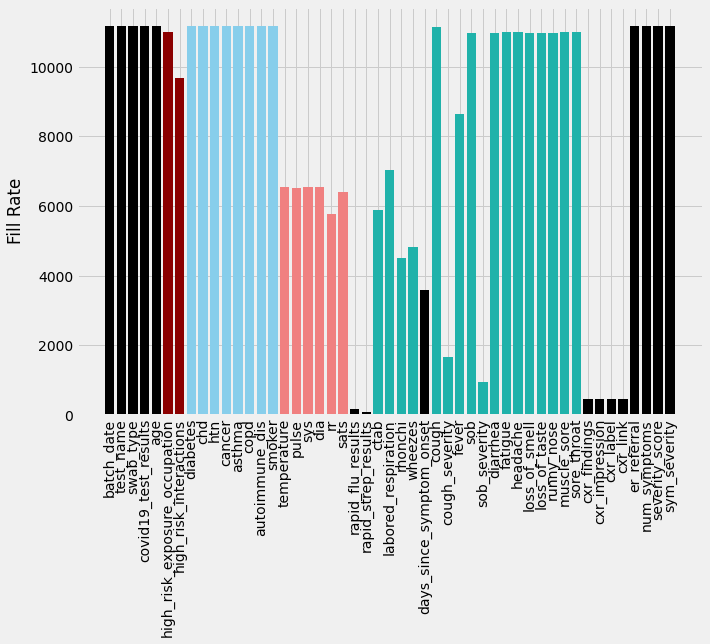

In [10]:
plot_fill_rates(data)